In [3]:
!pip install transformers

In [6]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import pandas as pd

# Try loading as a CSV file
try:
    dataset = load_dataset('csv', data_files='B2W-Reviews01.csv')
except Exception as e:
    print(f"Could not load dataset as CSV: {e}")
    # If loading as CSV fails, you might need to load it with pandas first
    try:
        df = pd.read_csv('B2W-Reviews01.csv')
        # Convert 'product_id' to string to handle mixed types
        df['product_id'] = df['product_id'].astype(str)
        dataset = Dataset.from_pandas(df)
        print("Loaded dataset using pandas and converted to Hugging Face Dataset.")
    except FileNotFoundError:
        print("Error: B2W-Reviews01.csv not found. Please make sure the file is in the correct directory.")
    except Exception as e_pandas:
        print(f"Could not load dataset with pandas: {e_pandas}")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Could not load dataset as CSV: Loading a dataset cached in a LocalFileSystem is not supported.
Loaded dataset using pandas and converted to Hugging Face Dataset.


/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


In [7]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding
import pandas as pd

# Try loading as a CSV file
try:
    dataset = load_dataset('csv', data_files='B2W-Reviews01.csv')
except Exception as e:
    print(f"Could not load dataset as CSV: {e}")
    # If loading as CSV fails, you might need to load it with pandas first
    try:
        df = pd.read_csv('B2W-Reviews01.csv')
        # Convert 'product_id' to string to handle mixed types
        df['product_id'] = df['product_id'].astype(str)
        # Split the dataframe into train and test sets
        train_df = df.sample(frac=0.8, random_state=42)
        test_df = df.drop(train_df.index)

        # Create datasets
        train_dataset = Dataset.from_pandas(train_df)
        test_dataset = Dataset.from_pandas(test_df)

        # Create a DatasetDict
        dataset = DatasetDict({
            'train': train_dataset,
            'test': test_dataset
        })
        print("Loaded dataset using pandas and converted to Hugging Face Dataset.")
    except FileNotFoundError:
        print("Error: B2W-Reviews01.csv not found. Please make sure the file is in the correct directory.")
    except Exception as e_pandas:
        print(f"Could not load dataset with pandas: {e_pandas}")

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Create label mapping based on overall_rating
def create_label(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

mapDict = {
    "positive": 0,
    "neutral": 1,
    "negative": 2
}

def transform_labels(example):
    label = create_label(example["overall_rating"])
    return {"label": mapDict[label]}

def tokenize_function(example):
    # Ensure the text is a string and not None
    text = str(example["review_text"]) if example["review_text"] is not None else ""
    return tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=512
    )

# First transform the labels
dataset = dataset.map(
    transform_labels,
    batched=False
)

# Then tokenize and remove other columns
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=False,
    remove_columns=[col for col in dataset["train"].column_names if col != "label"]
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Could not load dataset as CSV: Loading a dataset cached in a LocalFileSystem is not supported.
Loaded dataset using pandas and converted to Hugging Face Dataset.


Map:   0%|          | 0/2279 [00:00<?, ? examples/s]

Map:   0%|          | 0/570 [00:00<?, ? examples/s]

Map:   0%|          | 0/2279 [00:00<?, ? examples/s]

Map:   0%|          | 0/570 [00:00<?, ? examples/s]

In [ ]:
pip install --upgrade transformers

In [17]:
from transformers import TrainingArguments

output_dir = "./bert-financial-sentiment-analysis"
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=200,
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    do_eval=True,
    eval_strategy="steps",
    report_to="none"
)

In [18]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from transformers import Trainer
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-19-3549612176>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.731000,0.635083,0.736842
200,0.484500,0.550823,0.791228


TrainOutput(global_step=216, training_loss=0.5915137705979524, metrics={'train_runtime': 708.6818, 'train_samples_per_second': 9.647, 'train_steps_per_second': 0.305, 'total_flos': 1798906437006336.0, 'train_loss': 0.5915137705979524, 'epoch': 3.0})

In [21]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(570, 3) (570,)


In [22]:
trainer.evaluate()

{'eval_loss': 0.5508230924606323,
 'eval_accuracy': 0.7912280701754386,
 'eval_runtime': 19.8634,
 'eval_samples_per_second': 28.696,
 'eval_steps_per_second': 0.906,
 'epoch': 3.0}

In [23]:
print(df['product_id'].dtype)
print(df['product_id'].unique())

object
['132532965' '22562178' '113022329' ... '22982994' '7434992' '17989410']


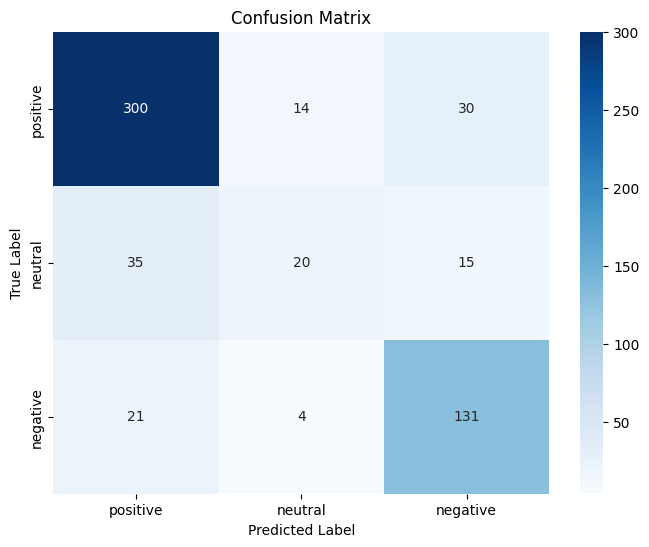


Classification Report:
              precision    recall  f1-score   support

    positive       0.84      0.87      0.86       344
     neutral       0.53      0.29      0.37        70
    negative       0.74      0.84      0.79       156

    accuracy                           0.79       570
   macro avg       0.70      0.67      0.67       570
weighted avg       0.78      0.79      0.78       570


Sample Predictions:
Review: Qual o tamanho da caixa desse relógio não tem na descrição...
True Label: neutral, Predicted Label: negative

Review: acabou as garrafinhas na geladeira,agua gelada direto da fonte....
True Label: positive, Predicted Label: positive

Review: Aparelho bom, e aprova d' água mas não funciona muito bem embaixo d' água o touch trava e volta ao n...
True Label: positive, Predicted Label: positive

Review: O produto chegou antes do tempo estipulado e parece ter boa qualidade. O preco foi muito interessant...
True Label: positive, Predicted Label: positive

Review: O 

In [24]:
# prompt: eu quero bisualizar o resultado de algumas predições

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming predictions and label_ids are already computed from trainer.predict()

# Convert raw logits to predicted class labels
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Get the true labels
true_labels = predictions.label_ids

# Visualize Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define the class names based on your mapDict
class_names = ["positive", "neutral", "negative"] # Assuming this order corresponds to 0, 1, 2

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Visualize Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# You can also display a few examples of predictions vs true labels
print("\nSample Predictions:")
sample_indices = np.random.choice(len(true_labels), 10, replace=False) # Get 10 random indices

# Inverse mapping from integer label to string label for display
inverse_mapDict = {v: k for k, v in mapDict.items()}

for i in sample_indices:
    true_label_str = inverse_mapDict[true_labels[i]]
    predicted_label_str = inverse_mapDict[predicted_labels[i]]
    # Access the original review text from the test dataset
    original_text = dataset["test"]["review_text"][i]
    print(f"Review: {original_text[:100]}...") # Print first 100 characters of the review
    print(f"True Label: {true_label_str}, Predicted Label: {predicted_label_str}\n")

